# Signal processing

This notebook will demonstrate some signal processing methods for determining range with an active remote sensing system. The next block of code can make and plot different pulse shapes. Select and run to define the functions.

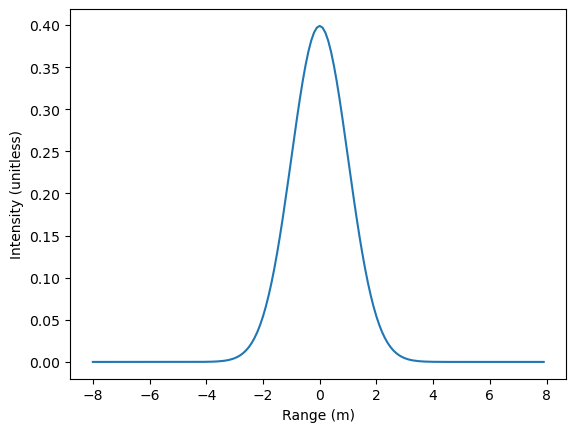

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi,sqrt

class setPulse():
    '''Class to hold and manipulate pulses'''
    
    def __init__(self,sigma,mode,res=0.1,A=1):
        '''Initialiser'''
        
        # save pulse properties within object
        self.sigma=sigma
        self.A=A
        self.res=res
        
        # behaviour depends upon pulse
        if(mode=="gauss"):
            self.x=np.arange(-sigma*8,sigma*8,res)
            self.y=A*np.exp(-1*self.x**2/(2*sigma**2))/(sigma*sqrt(2*pi))
        elif(mode=="chirp"):
            print('Not today')
        else:
            print(mode,"pulse shape mode not recognised.")
            print("mode must be gauss or chirp")
            
        return
            
            
    def plot(self):
        '''Plot the pulse'''
        plt.xlabel('Range (m)')
        plt.ylabel('Intensity (unitless)')
        plt.plot(self.x,self.y)
        plt.show()

    def correlate(self):
        #smooY=np.convolve(bData.wave[i,:],np.flip(pBy,axis=0),mode='same')   # flipped as distance is in reverse

        
        
########################
# Set and plot a pulse

mode="gauss"    # the type of pulse. "gauss" or "chirp"
sigma=1.0       # 1 m width

pulse=setPulse(sigma,mode)
pulse.plot()


## Changing the pulse shape

Have a go at making differtent pulse shapes by changing "mode", "sigma", "sFreq" and "eFreq" in the code block below.

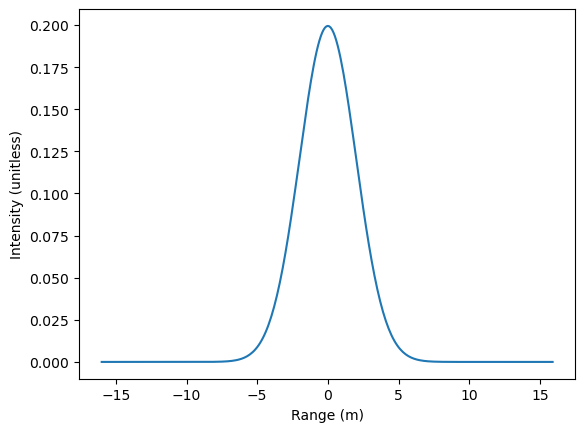

In [8]:
# pulse properties
mode="gauss"    # the type of pulse. "gauss" or "chirp"
sigma=2.0       # 1 m width


# set and plot a pulse with the properties from above
pulse=setPulse(sigma,mode)
pulse.plot()
